In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


# Model setting

In [2]:
def build_residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, is_50=False, is_plain=False):
    shortcut = x

    if not is_50:
        # ResNet-34 block
        if conv_shortcut:
            shortcut = Conv2D(filters, kernel_size=1, padding='same', strides=stride)(x)
            shortcut = BatchNormalization()(shortcut)

        x = Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)

        if not is_plain:
            x = Add()([x, shortcut])
    
    else:
        # ResNet-50 block
        
        # shortcut connection 추가 or 입력의 shape이 filters*4가 아닐때 shape 맞춰주기
        if conv_shortcut or x.shape[-1] != filters * 4:
            shortcut = Conv2D(filters * 4, kernel_size=1, padding='same', strides=stride)(shortcut)
            shortcut = BatchNormalization()(shortcut)

        x = Conv2D(filters, kernel_size=1, padding='same', strides=stride)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters * 4, kernel_size=1, padding='same')(x)
        x = BatchNormalization()(x)

        if not is_plain:
            x = Add()([x, shortcut])

    x = Activation('relu')(x)
    
    return x

In [3]:
def build_resnet(input_shape, num_classes, is_50, is_plain=False):
    inputs = Input(shape=input_shape)

    x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    if not is_50:
        # block 1: 3개 = 2 * 3 = 6개
        for _ in range(3):
            x = build_residual_block(x, 64, is_50=is_50, is_plain=is_plain)
        
        # block 2: shortcut이포함된 2개 + 2 * 3 = 2 * 4 = 8개
        x = build_residual_block(x, 128, stride=2, conv_shortcut=True, is_50=is_50, is_plain=is_plain)
        for _ in range(3):
            x = build_residual_block(x, 128, is_50=is_50, is_plain=is_plain)
        
        # block 3: shortcut이포함된 2개 + 2 * 5개 = 2 * 6 = 12개
        x = build_residual_block(x, 256, stride=2, conv_shortcut=True, is_50=is_50, is_plain=is_plain)
        for _ in range(5):
            x = build_residual_block(x, 256, is_50=is_50, is_plain=is_plain)
        
        # block 4: shortcut이포함된 2개 + 2 * 2개 = 2 * 3 = 6개
        # 총 입력으로받은 1개 + 6 + 8 + 12 + 6 + Dense층 1개 = 34layer
        x = build_residual_block(x, 512, stride=2, conv_shortcut=True, is_50=is_50, is_plain=is_plain)
        for _ in range(2):
            x = build_residual_block(x, 512, is_50=is_50, is_plain=is_plain)
    else:
        # block 1: 3개 = 3 * 3 = 9개
        for _ in range(3):
            x = build_residual_block(x, 64, is_50=is_50, is_plain=is_plain)
        
        # block 2: shortcut이포함된 3개 + 3 * 3 = 3 * 4 = 12개
        x = build_residual_block(x, 128, stride=2, conv_shortcut=True, is_50=is_50, is_plain=is_plain)
        for _ in range(3):
            x = build_residual_block(x, 128, is_50=is_50, is_plain=is_plain)
        
        # block 3: shortcut이포함된 3개 + 3 * 5개 = 3 * 6 = 18개
        x = build_residual_block(x, 256, stride=2, conv_shortcut=True, is_50=is_50, is_plain=is_plain)
        for _ in range(5):
            x = build_residual_block(x, 256, is_50=is_50, is_plain=is_plain)
        
        # block 4: shortcut이포함된 3개 + 3 * 2개 = 3 * 3 = 9개
        # 총 입력으로받은 1개 + 9 + 12 + 18 + 9 + Dense층 1개 = 50layer
        x = build_residual_block(x, 512, stride=2, conv_shortcut=True, is_50=is_50, is_plain=is_plain)
        for _ in range(2):
            x = build_residual_block(x, 512, is_50=is_50, is_plain=is_plain)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [4]:
"""
Total params: 21,315,338
Trainable params: 21,298,314
Non-trainable params: 17,024
"""
input_shape = (32, 32, 3)
num_classes = 10
resnet_34 = build_resnet(input_shape, num_classes, is_50=False, is_plain=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
"""
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
"""
input_shape = (32, 32, 3)
num_classes = 10
resnet_50 = build_resnet(input_shape, num_classes, is_50=True, is_plain=False)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [127]:
input_shape = (32, 32, 3)
num_classes = 10
plain_34 = build_resnet(input_shape, num_classes, is_50=False, is_plain=True)
plain_34.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_930 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_920 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_795 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_931 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_921 (Bat (None, 8, 8, 64)          256

In [128]:
input_shape = (32, 32, 3)
num_classes = 10
plain_50 = build_resnet(input_shape, num_classes, is_50=True, is_plain=True)
plain_50.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_966 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_956 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_828 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_968 (Conv2D)          (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_958 (Bat (None, 8, 8, 64)          256

# Data Load

In [47]:
import urllib3
urllib3.disable_warnings()

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [48]:
# feature 정보
print(ds_info.features)
# 갯수
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [49]:
def normalize_and_resize_img(data):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(data['image'], (32, 32))
    image = tf.cast(image, tf.float32) / 255.0
    label = data['label']
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [50]:
BATCH_SIZE = 256
EPOCH = 15

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [53]:
# # 사진 확인용
# print('-'*15,'train','-'*15)
# tfds.show_examples(ds_train, ds_info)
# print('-'*15,'test','-'*15)
# tfds.show_examples(ds_test, ds_info)

# model complie & fit

In [57]:
input_shape = (32, 32, 3)
num_classes = 2
resnet_34 = build_resnet(input_shape, num_classes, is_50=False, is_plain=False)

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd

12/72 [====>.........................] - ETA: 7s - loss: 1.0466 - accuracy: 0.5286

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


14/72 [====>.........................] - ETA: 7s - loss: 1.0253 - accuracy: 0.5340

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


18/72 [======>.......................] - ETA: 6s - loss: 0.9715 - accuracy: 0.5516

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


45/72 [=================>............] - ETA: 3s - loss: 0.8653 - accuracy: 0.5706

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.8603 - accuracy: 0.5693

50/72 [===================>..........] - ETA: 2s - loss: 0.8531 - accuracy: 0.5733

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.8336 - accuracy: 0.5813

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.5899

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marke

72/72 [==============================] - 62s 477ms/step - loss: 0.8124 - accuracy: 0.5899 - val_loss: 0.7075 - val_accuracy: 0.5189
Epoch 2/15
 1/72 [..............................] - ETA: 9s - loss: 0.6381 - accuracy: 0.6445

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


13/72 [====>.........................] - ETA: 6s - loss: 0.6687 - accuracy: 0.6593

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


15/72 [=====>........................] - ETA: 6s - loss: 0.6826 - accuracy: 0.6508

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 6s - loss: 0.6946 - accuracy: 0.6462

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 5s - loss: 0.6989 - accuracy: 0.6369

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 3s - loss: 0.6804 - accuracy: 0.6408

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


50/72 [===================>..........] - ETA: 2s - loss: 0.6774 - accuracy: 0.6419

51/72 [====================>.........] - ETA: 2s - loss: 0.6741 - accuracy: 0.6436

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.6577 - accuracy: 0.6570

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6616

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marke

72/72 [==============================] - 34s 472ms/step - loss: 0.6499 - accuracy: 0.6616 - val_loss: 0.6961 - val_accuracy: 0.5164
Epoch 3/15
 1/72 [..............................] - ETA: 8s - loss: 0.3106 - accuracy: 0.9141

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


14/72 [====>.........................] - ETA: 5s - loss: 0.5717 - accuracy: 0.7165

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


15/72 [=====>........................] - ETA: 5s - loss: 0.5631 - accuracy: 0.7227

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 5s - loss: 0.5562 - accuracy: 0.7287

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 2s - loss: 0.5288 - accuracy: 0.7465

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


51/72 [====================>.........] - ETA: 2s - loss: 0.5236 - accuracy: 0.7501

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 1s - loss: 0.5219 - accuracy: 0.7502

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7505

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marke

72/72 [==============================] - 34s 473ms/step - loss: 0.5223 - accuracy: 0.7505 - val_loss: 0.7108 - val_accuracy: 0.4989
Epoch 4/15
 1/72 [..............................] - ETA: 9s - loss: 0.2745 - accuracy: 0.9297

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


10/72 [===>..........................] - ETA: 5s - loss: 0.5156 - accuracy: 0.7512

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


14/72 [====>.........................] - ETA: 5s - loss: 0.4901 - accuracy: 0.7667

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 4s - loss: 0.4819 - accuracy: 0.7697

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


48/72 [===================>..........] - ETA: 2s - loss: 0.4795 - accuracy: 0.7762

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


52/72 [====================>.........] - ETA: 2s - loss: 0.4838 - accuracy: 0.7733

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 1s - loss: 0.4927 - accuracy: 0.7683

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.7730

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marke

72/72 [==============================] - 34s 483ms/step - loss: 0.4830 - accuracy: 0.7730 - val_loss: 0.7409 - val_accuracy: 0.5178
Epoch 5/15
 1/72 [..............................] - ETA: 8s - loss: 0.3621 - accuracy: 0.8594

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 6/72 [=>............................] - ETA: 6s - loss: 0.3842 - accuracy: 0.8372

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.3559 - accuracy: 0.8494

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


52/72 [====================>.........] - ETA: 1s - loss: 0.3531 - accuracy: 0.8508

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


63/72 [=========================>....] - ETA: 0s - loss: 0.3575 - accuracy: 0.8493

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8533

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 35s 494ms/step - loss: 0.3504 - accuracy: 0.8533 - val_loss: 0.8173 - val_accuracy: 0.5198
Epoch 6/15
 1/72 [..............................] - ETA: 8s - loss: 0.2154 - accuracy: 0.9297

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


30/72 [===========>..................] - ETA: 3s - loss: 0.3339 - accuracy: 0.8585

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


37/72 [==============>...............] - ETA: 3s - loss: 0.3174 - accuracy: 0.8662

39/72 [===============>..............] - ETA: 2s - loss: 0.3161 - accuracy: 0.8667

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


53/72 [=====================>........] - ETA: 1s - loss: 0.3132 - accuracy: 0.8684

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8742

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 33s 468ms/step - loss: 0.3020 - accuracy: 0.8742 - val_loss: 0.8738 - val_accuracy: 0.5503
Epoch 7/15
 1/72 [..............................] - ETA: 8s - loss: 0.1774 - accuracy: 0.9336

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


30/72 [===========>..................] - ETA: 3s - loss: 0.2254 - accuracy: 0.9156

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


36/72 [==============>...............] - ETA: 3s - loss: 0.2203 - accuracy: 0.9174

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


54/72 [=====================>........] - ETA: 1s - loss: 0.2017 - accuracy: 0.9253

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9261

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 33s 469ms/step - loss: 0.1969 - accuracy: 0.9261 - val_loss: 1.0630 - val_accuracy: 0.5753
Epoch 8/15
 1/72 [..............................] - ETA: 9s - loss: 0.0907 - accuracy: 0.9688

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


31/72 [===========>..................] - ETA: 3s - loss: 0.1652 - accuracy: 0.9409

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


38/72 [==============>...............] - ETA: 2s - loss: 0.1619 - accuracy: 0.9422

41/72 [================>.............] - ETA: 2s - loss: 0.1650 - accuracy: 0.9407

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


56/72 [======================>.......] - ETA: 1s - loss: 0.1608 - accuracy: 0.9408

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9451

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 33s 469ms/step - loss: 0.1492 - accuracy: 0.9451 - val_loss: 1.1412 - val_accuracy: 0.5770
Epoch 9/15
 1/72 [..............................] - ETA: 8s - loss: 0.1710 - accuracy: 0.9336

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


33/72 [============>.................] - ETA: 3s - loss: 0.1340 - accuracy: 0.9480

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


39/72 [===============>..............] - ETA: 2s - loss: 0.1259 - accuracy: 0.9522

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


56/72 [======================>.......] - ETA: 1s - loss: 0.1184 - accuracy: 0.9568

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9564 ETA: 1s - loss: 0

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 34s 474ms/step - loss: 0.1187 - accuracy: 0.9564 - val_loss: 1.1466 - val_accuracy: 0.6121
Epoch 10/15
 1/72 [..............................] - ETA: 8s - loss: 0.1154 - accuracy: 0.9609

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


34/72 [=============>................] - ETA: 3s - loss: 0.0988 - accuracy: 0.9640

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


40/72 [===============>..............] - ETA: 2s - loss: 0.0973 - accuracy: 0.9647

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


57/72 [======================>.......] - ETA: 1s - loss: 0.1001 - accuracy: 0.9637

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9622

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 34s 475ms/step - loss: 0.1037 - accuracy: 0.9622 - val_loss: 1.2342 - val_accuracy: 0.6085
Epoch 11/15
 1/72 [..............................] - ETA: 8s - loss: 0.1115 - accuracy: 0.9648

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


36/72 [==============>...............] - ETA: 3s - loss: 0.1027 - accuracy: 0.9629

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


42/72 [================>.............] - ETA: 2s - loss: 0.0999 - accuracy: 0.9640

44/72 [=================>............] - ETA: 2s - loss: 0.1023 - accuracy: 0.9634

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


59/72 [=======================>......] - ETA: 1s - loss: 0.1071 - accuracy: 0.9610

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9639

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 33s 469ms/step - loss: 0.0993 - accuracy: 0.9639 - val_loss: 1.4194 - val_accuracy: 0.6156
Epoch 12/15
 1/72 [..............................] - ETA: 8s - loss: 0.1001 - accuracy: 0.9648

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


38/72 [==============>...............] - ETA: 3s - loss: 0.0877 - accuracy: 0.9679

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


44/72 [=================>............] - ETA: 2s - loss: 0.0855 - accuracy: 0.9692

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 0s - loss: 0.0870 - accuracy: 0.9688

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 33s 466ms/step - loss: 0.0919 - accuracy: 0.9667 - val_loss: 1.5450 - val_accuracy: 0.5933
Epoch 13/15
 1/72 [..............................] - ETA: 8s - loss: 0.0433 - accuracy: 0.9883

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


40/72 [===============>..............] - ETA: 2s - loss: 0.0806 - accuracy: 0.9719

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 2s - loss: 0.0825 - accuracy: 0.9715

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


65/72 [==========================>...] - ETA: 0s - loss: 0.0845 - accuracy: 0.9698

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9695

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 34s 473ms/step - loss: 0.0842 - accuracy: 0.9695 - val_loss: 1.5853 - val_accuracy: 0.6235
Epoch 14/15
 1/72 [..............................] - ETA: 8s - loss: 0.1578 - accuracy: 0.9453

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 2s - loss: 0.0827 - accuracy: 0.9699

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


53/72 [=====================>........] - ETA: 1s - loss: 0.0851 - accuracy: 0.9686

55/72 [=====================>........] - ETA: 1s - loss: 0.0844 - accuracy: 0.9686

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


71/72 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9681

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9683

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before mark

72/72 [==============================] - 34s 478ms/step - loss: 0.0860 - accuracy: 0.9683 - val_loss: 1.5861 - val_accuracy: 0.6236
Epoch 15/15
 1/72 [..............................] - ETA: 8s - loss: 0.0330 - accuracy: 0.9883

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


45/72 [=================>............] - ETA: 2s - loss: 0.0672 - accuracy: 0.9764

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


52/72 [====================>.........] - ETA: 1s - loss: 0.0713 - accuracy: 0.9739

54/72 [=====================>........] - ETA: 1s - loss: 0.0715 - accuracy: 0.9739

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


70/72 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9733

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9732

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marke

72/72 [==============================] - 34s 475ms/step - loss: 0.0717 - accuracy: 0.9732 - val_loss: 1.4688 - val_accuracy: 0.6341


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


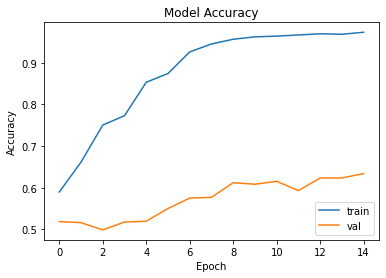

In [64]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.plot(histoty_34.history['accuracy'])
plt.plot(histoty_34.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

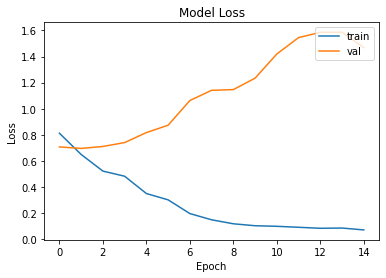

In [63]:
# loss 그래프
plt.plot(histoty_34.history['loss'])
plt.plot(histoty_34.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
input_shape = (32, 32, 3)
num_classes = 2
resnet_50 = build_resnet(input_shape, num_classes, is_50=True, is_plain=False)


resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
input_shape = (32, 32, 3)
num_classes = 2
plain_34 = build_resnet(input_shape, num_classes, is_50=False, is_plain=True)

plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
input_shape = (32, 32, 3)
num_classes = 2
plain_50 = build_resnet(input_shape, num_classes, is_50=True, is_plain=True)

plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# 회고

- ResNet34와 50 구현방법을 배웠었다.
- ResNet34에서 layer몇개만 쌓으면 ResNet 50이 될줄알았는데 직접 구현하지 못했고 블로그 글에서 방법을 찾았다
- 구현하는 것에 있어서 아직 정확히 이해하지 못했다.

## 6시 이후 회고
- 6시 이후에 따로 더 해서 블로그 코드 말고 chatgpt 물어보면서 따로 구현
- model fit은 너무오래걸려서 resnet_34만 시도...